In [25]:

!pip -q install langchain openai tiktoken chromadb
!pip install -U langchain-community
!pip install rank_bm25

In [2]:
from key import OPENAI_API_KEY

In [6]:

import os
from langchain.embeddings.openai import OpenAIEmbeddings

env_vars = {
    "OPENAI_API_KEY": OPENAI_API_KEY,
}

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n" + d.page_content for i, d in enumerate(docs)]))

for key, value in env_vars.items():
    os.environ[key] = value

embedding = OpenAIEmbeddings(chunk_size=1 )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [7]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma

from langchain.schema import Document

# Load blog post
from langchain.document_loaders import TextLoader

loader = TextLoader("./dogs.txt")
data = loader.load()
loader = TextLoader("./restaurant.txt")
data2 = loader.load()

docs = data + data2


#text_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=10)
#docs = text_splitter.split_documents(data)


In [9]:
len(docs)

2

In [12]:
for doc in docs:

    print()
    print(doc.page_content)
    print()


Fiktive Hundeschule: Canine Academy
Q1: What is the name of the dog training school?
A1: The school is called "Canine Academy".

Q2: Where is Canine Academy located?
A2: Canine Academy is located in the suburbs, near the community park.

Q3: What training programs are offered at Canine Academy?
A3: They offer basic obedience, agility training, and advanced behavioral courses.

Q4: Are there any special qualifications for the trainers at Canine Academy?
A4: All trainers are certified and have years of experience in dog training and behavior.

Q5: Can Canine Academy help with specific behavioral issues?
A5: Yes, they offer personalized training sessions for issues like aggression, anxiety, and barking.

Q6: How long do the training courses last?
A6: The courses vary, ranging from 4-week short courses to 12-week intensive programs.

Q7: Does Canine Academy provide training for service or therapy dogs?
A7: Yes, they have specialized programs for service and therapy dog training.

Q8: Is t

In [10]:
vector1 = embedding.embed_query("How is the whether??")
vector2 = embedding.embed_query("What is the Name of the Dogschool?")
vector3 = embedding.embed_query("What food do you offer?")

data_vectors = [embedding.embed_query(doc.page_content) for doc in docs]
print(len(data_vectors))

2


In [13]:
len(data_vectors[0])

1536

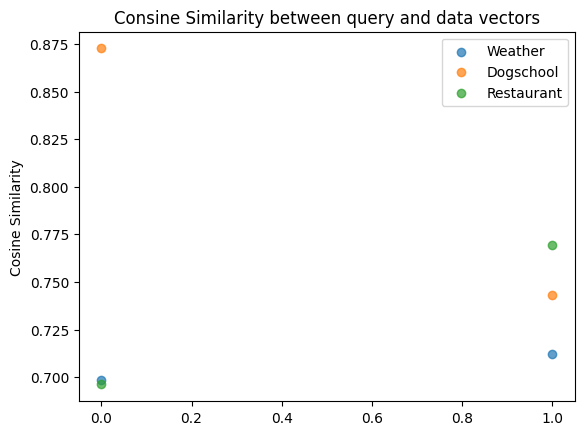

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

cosine_sims_1 = [cosine_similarity([vector1], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_2 = [cosine_similarity([vector2], [data_vector])[0][0] for data_vector in data_vectors]
cosine_sims_3 = [cosine_similarity([vector3], [data_vector])[0][0] for data_vector in data_vectors]

x = np.arange(len(data_vectors))

plt.scatter(x, cosine_sims_1, label='Weather', alpha=0.7)
plt.scatter(x, cosine_sims_2, label='Dogschool', alpha=0.7)
plt.scatter(x, cosine_sims_3, label='Restaurant', alpha=0.7)

plt.ylabel('Cosine Similarity')
plt.title('Consine Similarity between query and data vectors')
plt.legend()

plt.show()

In [31]:

from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

child_splitter = RecursiveCharacterTextSplitter(chunk_size=120, chunk_overlap=20)
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=20)
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

In [32]:
vectorstore

In [33]:
retriever.add_documents(docs, ids=None)

KeyboardInterrupt: 

In [ ]:
vectorstore.similarity_search("What is the name of the dog school?")

In [ ]:
retriever.get_relevant_documents("What is the name of the dog school?")

### MultiQueryRetriever

Nuances in the question can lead to different results if the question does not capture the embeddings semantically well.
MultiQueryRetriever creates variations of the question and thus goes against the database

In [34]:
vectordb = Chroma.from_documents(documents=docs , embedding=embedding)

In [35]:
vectordb

In [36]:
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

llm = ChatOpenAI(
        temperature=0,
        max_tokens=800,
        model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
    )


retriever = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

In [37]:
unique_docs = retriever.get_relevant_documents("Who is Mike")
len(unique_docs)

2

In [38]:
unique_docs

[Document(page_content='Fiktives Restaurant: Gourmet\'s Delight\nQ1: What is the name of the restaurant?\nA1: The restaurant is named "Gourmet\'s Delight".\n\nQ2: Where is Gourmet\'s Delight located?\nA2: It is located in the heart of downtown, on Maple Street.\n\nQ3: What type of cuisine does Gourmet\'s Delight offer?\nA3: Gourmet\'s Delight specializes in a fusion of Mediterranean and Asian cuisine.\n\nQ4: Is the restaurant vegetarian-friendly?\nA4: Yes, there is a wide range of vegetarian and vegan options available.\n\nQ5: Does Gourmet\'s Delight accept reservations?\nA5: Yes, guests are encouraged to make reservations, especially on weekends.\n\nQ6: Are there any special dishes that are recommended at Gourmet\'s Delight?\nA6: The signature dish is the \'Medit-Asian Fusion Platter\' which includes a variety of specialties.\n\nQ7: What are the operating hours of the restaurant?\nA7: The restaurant is open from 11:00 AM to 10:00 PM, Monday through Sunday.\n\nQ8: Does Gourmet\'s Delig

In [19]:
from typing import List

from langchain.chains import LLMChain
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field


class LineList(BaseModel):
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)

llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [ ]:
llm_chain.invoke("What is the name of the dog school?")

In [28]:
question = "What is the name of the dog school?"


### Contextual Compression

To use the Contextual Compression Retriever, you need:

    a basic retriever
    a document compressor

The Contextual Compression Retriever passes queries to the Base Retriever, takes the source documents and forwards them to the Document Compressor. The document compressor takes a list of documents and shortens them by reducing the content of documents or omitting documents altogether.

In [ ]:
vectorstore = Chroma(
    collection_name="full_documents", embedding_function=embedding
)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever()

In [ ]:
retriever.get_relevant_documents(query=question)

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.5)
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

In [ ]:
from langchain.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter

splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embedding)
relevant_filter = EmbeddingsFilter(embeddings=embedding, similarity_threshold=0.76)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[splitter, redundant_filter, relevant_filter]
)

compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline_compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents(query=question)
pretty_print_docs(compressed_docs)

### Ensemble Retriever

In [26]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever


bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = 2

chroma_vectorstore = Chroma.from_documents(docs, embedding)
chroma_retriever = chroma_vectorstore.as_retriever()

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_retriever], weights=[0.5, 0.5]
)

In [29]:
docs = ensemble_retriever.get_relevant_documents(query=question)
docs

[Document(page_content='Fiktive Hundeschule: Canine Academy\nQ1: What is the name of the dog training school?\nA1: The school is called "Canine Academy".\n\nQ2: Where is Canine Academy located?\nA2: Canine Academy is located in the suburbs, near the community park.\n\nQ3: What training programs are offered at Canine Academy?\nA3: They offer basic obedience, agility training, and advanced behavioral courses.\n\nQ4: Are there any special qualifications for the trainers at Canine Academy?\nA4: All trainers are certified and have years of experience in dog training and behavior.\n\nQ5: Can Canine Academy help with specific behavioral issues?\nA5: Yes, they offer personalized training sessions for issues like aggression, anxiety, and barking.\n\nQ6: How long do the training courses last?\nA6: The courses vary, ranging from 4-week short courses to 12-week intensive programs.\n\nQ7: Does Canine Academy provide training for service or therapy dogs?\nA7: Yes, they have specialized programs for 

### Self-Querying retriever

A self-querying retriever is a retriever that, as the name suggests, has the ability to
the ability to query itself. More precisely, any natural language query,
 the retriever uses an LLM chain for query construction to write a structured query
 structured query and then applies this structured query to the underlying
VectorStore. This allows the retriever to not only use the query entered by the user
query for the semantic similarity comparison with the content of the stored
documents, but also apply filters from the user query to the metadata of the stored
metadata of the stored documents and execute these filters.

In [ ]:
from langchain.schema import Document
from langchain.vectorstores import Chroma

docs = [
    Document(
        page_content="Bello-Basistraining offers a comprehensive foundation for dog obedience, focusing on basic commands and socialization.",
        metadata={"type": "Basic Training", "feature": "Foundational Skills", "price": "Affordable"},
    ),
    Document(
        page_content="Pfote-Agilitykurs provides a fun and energetic way to keep dogs fit and mentally stimulated through obstacle courses.",
        metadata={"type": "Agility Training", "feature": "Physical Fitness", "price": "Moderate"},
    ),
    Document(
        page_content="Wuff-Verhaltensberatung specializes in addressing behavioral issues, offering tailored strategies for each dog.",
        metadata={"type": "Behavioral Consultation", "feature": "Customized Solutions", "price": "Premium"},
    ),
    Document(
        page_content="Schwanzwedeln-Therapiehundausbildung prepares dogs for roles in therapeutic and support settings, focusing on empathy and gentleness.",
        metadata={"type": "Therapy Dog Training", "feature": "Emotional Support", "price": "High"},
    ),
    Document(
        page_content="Schnüffler-Suchhundetraining trains dogs in scent detection, useful for search and rescue operations.",
        metadata={"type": "Search and Rescue Training", "feature": "Advanced Skills", "price": "Variable"},
    ),
    Document(
        page_content="Hunde-Haftpflichtversicherung offers comprehensive coverage for potential damages or injuries caused by your dog.",
        metadata={"type": "Dog Liability Insurance", "feature": "Financial Protection", "price": "Varies"},
    ),
]

vectorstore = Chroma.from_documents(docs, embedding)


In [ ]:
from langchain.vectorstores import Chroma
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="type",
        description="The type of dog training service (e.g., Basic Training, Agility Training, Behavioral Consultation)",
        type="string",
    ),
    AttributeInfo(
        name="feature",
        description="Special features or benefits of the service",
        type="string",
    ),
    AttributeInfo(
        name="price",
        description="Price category of the service (e.g., Affordable, Moderate, Premium)",
        type="string",
    ),
]

document_content_description = "Description of a dog training service"
retriever = SelfQueryRetriever.from_llm(
    llm,
    vectorstore,
    document_content_description,
    metadata_field_info,
)


In [ ]:
retriever.invoke("What Premium priced trainings do you offer?")

### Time-weighted vector store retriever

In [ ]:
import faiss

from datetime import datetime, timedelta
from langchain.docstore import InMemoryDocstore
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain.schema import Document
from langchain.vectorstores import FAISS

In [ ]:

# decay_rate = .0000000000000000000000001
decay_rate = .999

embedding_size = 1536
index = faiss.IndexFlatL2(embedding_size)
vectorstore = FAISS(embedding, index, InMemoryDocstore({}), {})
retriever = TimeWeightedVectorStoreRetriever(vectorstore=vectorstore, decay_rate=decay_rate, k=1)

In [ ]:
yesterday = datetime.now() - timedelta(days=1)
retriever.add_documents([Document(page_content="hello world", metadata={"last_accessed_at": yesterday})])
retriever.add_documents([Document(page_content="hello foo")])

In [ ]:
retriever.get_relevant_documents("hello world")